# Deep Q-learning using backprop on small grdiworld

In [1]:
import os
os.chdir("..")
from src.gym_kalman.env_Gridworld import GridworldEnv

In [2]:
# Initialize value function
import numpy as np

# initialize the environment
grid_size = 4
env = GridworldEnv(grid_size=grid_size, reward_std=0.)
num_states = env.observation_space.n
actions = np.arange(env.action_space.n)

In [3]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
def state_encoder(state):
    # one hot encoding
    state_onehot = np.zeros(num_states)
    state_onehot[state] = 1
    return state_onehot

def state_decoder(state_onehot):
    return np.argmax(state_onehot)

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 1
EPS_START = 0.9
EPS_END = 0.0001
EPS_DECAY = 1000

TAU = 0.005
LR = 1e-2

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = 16

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def select_greedy_action(state):
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1, 1)

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [9]:
# Extract current policy
def extract_policy(num_states, episode_i):
    policy = np.zeros(num_states)
    for state in range(num_states):
        if state == 15:  # Terminal state
            policy[state] = 10
            continue
        state_encoded = state_encoder(state)
        state_tensor = torch.tensor(state_encoded, dtype=torch.float32, device=device).unsqueeze(0)
        suggested_action = select_greedy_action(state_tensor)
        policy[state] = suggested_action

    policy_grid = np.array(policy).reshape((grid_size, grid_size))
    # Print title of the plot
    print(f"Episode {episode_i}'s policy")
    print(policy_grid)
    return

def print_state_values(num_states, i_episode):
    ########################## Print the state values ##########################
    print(f"\nEpisode {i_episode}'s state values")
    values = np.zeros(num_states)
    for state in range(num_states):
        if state == 15:  # Terminal state
            continue
        state_encoded = state_encoder(state)
        state_tensor = torch.tensor(state_encoded, dtype=torch.float32, device=device).unsqueeze(0)
        suggested_action = select_greedy_action(state_tensor)
        with torch.no_grad():
            values[state] = policy_net(state_tensor)[0].tolist()[suggested_action]

    value_grid = np.array(values).reshape((grid_size, grid_size))
    value_grid = np.round(value_grid, 2)
    print(value_grid)

true_values_grid = np.array([-6, -5, -4, -3,
                              -5, -4, -3, -2,
                              -4, -3, -2, -1,
                              -3, -2, -1, 0.0]).reshape((grid_size, grid_size))

true_values_std_grid = np.array([0.49, 0.45, 0.4, 0.35,
                                 0.45, 0.4, 0.35, 0.28,
                                 0.4, 0.35, 0.28, 0.2,
                                 0.35, 0.28, 0.2, 0.0]).reshape((grid_size, grid_size))

def plot_value_distribution(episode_i, state_trace, finished=False):
    values = np.zeros(num_states)
    for state in range(num_states):
        if state == 15:  # Terminal state
            continue
        norm_state = state_encoder(state)
        state_tensor = torch.tensor(norm_state, dtype=torch.float32, device=device).unsqueeze(0)
        suggested_action = select_greedy_action(state_tensor)

        with torch.no_grad():
            values[state] = policy_net(state_tensor)[0].tolist()[suggested_action]

    value_grid = np.array(values).reshape((grid_size, grid_size))
    value_grid = np.round(value_grid, 2)

    # Set the grid to zero if it is not in the trace
    visited_grid = np.zeros((grid_size, grid_size))
    for i in range(4):
        for j in range(4):
            if i*4 + j in state_trace:
                visited_grid[i, j] = 1

    x = np.linspace(-7, 1, 50)
    # Plot 16 gaussian curves in a 4 by 4 grid
    plt.figure(1)
    if not finished:
        plt.clf()
        plt.suptitle(f"Episode {episode_i+1}: state value distribution")
    else:
        plt.suptitle(f"Sate value distribution")

    for i in range(4):
        for j in range(4):
            plt.subplot(4, 4, i*4+j+1)
            # Set the background color of the plot to gray if it is not in the trace grid
            if visited_grid[i, j] == 0:
                plt.gca().set_facecolor('lightgrey')
            if i*4 + j != 15:
                plt.title("")
                if i*4 + j == 0:
                    plt.xlabel("Start", fontsize=8)
                plt.plot(x, 1/(true_values_std_grid[i, j] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - true_values_grid[i, j])**2 / (2 * true_values_std_grid[i, j]**2) ),
                            linewidth=2, color='r', label='True')
                plt.axvline(value_grid[i, j], color='g', label='Estimated')

            else:
                plt.plot(x+10, 10+1/(true_values_std_grid[0, 0] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - true_values_grid[0, 0])**2 / (2 * true_values_std_grid[0, 0]**2) ),
                            linewidth=2, color='r', label='True')
                plt.axvline(value_grid[i, j]+100, color='g', label='Estimated')
                plt.gca().set_facecolor('yellow')
                plt.xlabel("Goal", fontsize=8)
            plt.xlim(-7, 1)
            plt.xticks([])
            plt.yticks([])
    plt.legend(['True', 'Pred'], loc='upper right')
    plt.pause(0.001)
    from IPython import display
    if not finished:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())
    return

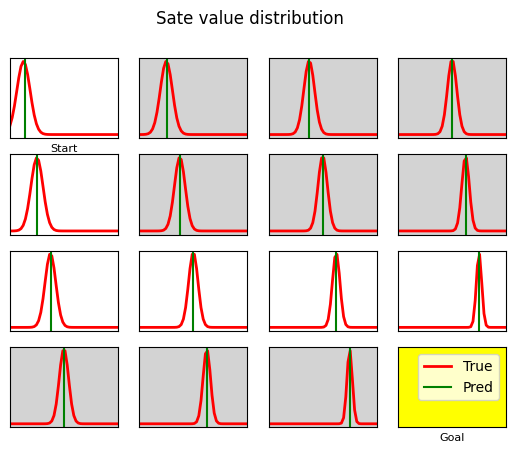

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>

In [10]:
num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = state_encoder(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state_trace = []
    for t in count():
        state_trace.append(state_decoder(state.tolist()[0]))

        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = state_encoder(observation)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    # Remove the repeated grids in the grid trace
    state_trace = list(dict.fromkeys(state_trace))

    if i_episode % 1 == 0:
        plot_value_distribution(i_episode, state_trace)
    if i_episode == num_episodes - 1:
        plot_value_distribution(i_episode, state_trace, finished=True)

print('Complete')